In [2]:
%matplotlib inline
import numpy as np
import pandas as p
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import random
sns.set_style("white")
sns.set(style="ticks")
from matplotlib import rc
rc('text', usetex=True)
sns.set_color_codes()

In [8]:
import operator as op
def ncr(n, r):
    if r > n: return 0
#     print n, r, n-r
    r = min(r, n-r)
    if r == 0: return 1
    numer = reduce(op.mul, xrange(n, n-r, -1))
    denom = reduce(op.mul, xrange(1, r+1))
    return numer//denom

def strandlength_distribution(NumCells,r,MaxLength):
    
    b = r
    g = 1/(float(NumCells)+1)
    
    geometric = [( ((b*(1-g))/(b+g*(1-b)))**k * (g/(b+g*(1-b))) ) for k in range(MaxLength)]
    geometric.append(1-sum(geometric))

    return geometric

def pull_from_strandlength_distribution(N,NumCells,r,MaxLength):
    
    unifs = np.random.uniform(0,1,N)
    
    geometric = strandlength_distribution(NumCells,r,MaxLength)
    
    geometric_cum = np.cumsum(geometric)
    
    lengths = [np.where(unif < geometric_cum)[0][0] for unif in unifs]
    
    return lengths

## Naive method of simulating all strands ##
def old_motif_freq(b,motif,numCells,r,maxLength):
    
    sl_dist = strandlength_distribution(numCells,r,maxLength)
    motiffreq = 0
    for k in range(len(motif),maxLength+1):
        lengthlist = map(''.join, itertools.product('10', repeat=k))

        lengthlist = [string for string in lengthlist if motif in string]
        strand_probs = [b**(s.count('0'))*(1-b)**(s.count('1'))   for s in lengthlist]

        motiffreq = motiffreq + sl_dist[k]*sum([strand_probs[s] for s in range(len(lengthlist)) if motif in lengthlist[s]])
        
    return motiffreq, motiffreq/(1-sl_dist[0])

## Faster Brute force method of simulating the strands ##
def motif_freq(b,motif,numCells,r,maxLength):
    
    sl_dist = strandlength_distribution(numCells,r,maxLength)
    motiffreq = 0
    motif_containing_strands = [motif]
    last_length = len(motif)
    last_length_list = [motif]
    for k in range(1,maxLength+1-len(motif)):
        # k is non-motif digits
        lengthlist = map(''.join, itertools.product('10', repeat=k))
        
        new_length_0 = [s + '0' for s in last_length_list]
        new_length_1 = [s + '1' for s in last_length_list]
        
        new_length = [s + motif for s in lengthlist]
        
        last_length_list = new_length_0 + new_length_1
        combined = last_length_list + new_length
        last_length_list = list(np.unique(last_length_list + new_length))
        
        motif_containing_strands += last_length_list
        
    strand_probs = [sl_dist[len(s)]*b**(s.count('0'))*(1-b)**(s.count('1'))   for s in motif_containing_strands]

    motiffreq = sum(strand_probs)
        
    return motiffreq, motiffreq/(1-sl_dist[0])

## Analytical Derivation for non-overlapping motifs ##
def motif_freq_analytical(b,motif,numCells,r,maxLength):
    
    sl_dist = strandlength_distribution(numCells,r,maxLength)
    
    m0 = motif.count('0')
    l = len(motif)
    
    motiffreq = 0
    
    for lam in range(l,maxLength+1):
        this_length_prob = 0
        
        this_length_prob += (lam-l+1)*b**m0*(1-b)**(l-m0)*sum([ncr(lam-l,k)*b**k*(1-b)**(lam-l-k)  for k in range(lam-l+1)])
        if np.floor(lam/l) >= 2:
            for beta in range(2,np.int(np.floor(lam/l))+1):
                this_length_prob +=  sum([(-1)**(beta+1)*ncr(lam-beta*l+beta,beta)*b**(beta*m0)*(1-b)**(beta*(l-m0))*sum([ncr(lam-beta*l,k)*b**k*(1-b)**(lam-beta*l-k) for k in range(lam-beta*l+1)])])

        motiffreq += sl_dist[lam]*this_length_prob
#         print motiffreq
        
    
    return motiffreq, motiffreq/(1-sl_dist[0])

def multiple_overlap_detector(motif):
    l = len(motif)
    o_len = [0]
    o0 = [0]
    for iterator in range(1,l):
        if motif[:l-iterator] == motif[iterator:]:
            o_len.append(l-iterator)
            o0.append(motif[:l-iterator].count('0'))
    if len(o_len) == 0:
        o_len.append(0)
        o0.append(0)
    return o_len, o0

## Analytical Derivation for motifs with multiple overlaps ##
def motif_freq_analytical_multipleoverlap(b,motif,numCells,r,maxLength):
    
    sl_dist = strandlength_distribution(numCells,r,maxLength)
    
    m0 = motif.count('0')
    l = len(motif)
    o_len_list, o0_list = multiple_overlap_detector(motif)

    motiffreq = 0
    
    for lam in range(l,maxLength+1):
        this_length_prob = 0

        for o_len, o0 in zip(o_len_list,o0_list):
            if o_len == 0:
                if np.floor(lam/l) >= 1:
                    for beta in range(1,np.int(np.floor(lam/l))+1):
                        this_length_prob += (-1)**(beta+1)*ncr(lam-beta*l+beta,beta)*b**(beta*m0)*(1-b)**(beta*(l-m0))
            else:
                for alpha in range(1,np.int(np.floor((lam-(l+l-o_len))/l))+2):

                    if alpha+np.int(np.floor((lam-alpha*l)/(l-o_len))) >= alpha:
                        for beta in range(alpha+1,alpha+np.int(np.floor((lam-alpha*l)/(l-o_len)))+1):
                            this_length_prob += (-1)**(beta+1)*(alpha**(beta-alpha)*ncr(lam-alpha*l-(beta-alpha)*(l-o_len)+alpha,alpha))*b**(alpha*m0+(beta-alpha)*(m0-o0))*(1-b)**(alpha*(l-m0)+(beta-alpha)*(l-m0-(o_len-o0)))

        motiffreq += sl_dist[lam]*this_length_prob
    
    return motiffreq, motiffreq/(1-sl_dist[0])

def cells_with_motif(b,motif,numCells,r,maxLength,numStrands):

    motif_prob = motif_freq_analytical(b,motif,numCells,r,maxLength)[0]
    
    p_cell_with_motif = 1-(1-motif_prob)**numStrands
    
    return p_cell_with_motif

def steady_state_motif_dist(b,motif,numCells,r,maxLength,numStrands):
    
    motif_prob, non_empty_motif_freq = motif_freq_analytical(b,motif,numCells,r,maxLength)
    
    p_cell_with_motif = 1-(1-motif_prob)**numStrands
    
    p_cell_with_motif = cells_with_motif(0.5,motif,numCells,r,maxLength,numStrands)
    
    ss_motif_freq = p_cell_with_motif*non_empty_motif_freq
    
    return ss_motif_freq
    

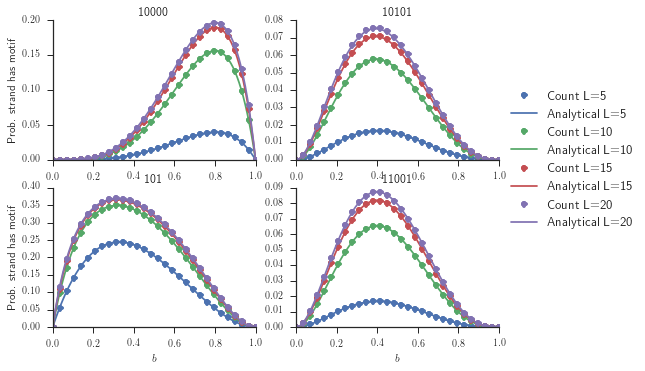

In [28]:
ax = plt.figure()
plt.subplot(221)
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'10000',100,0.05,5)[1] for b in np.linspace(0.0,1,30)],'bo',label='Brute Force Count')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'10000',100,0.05,5)[1] for b in np.linspace(0.0,1,100)],'b',label='Analytical')
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'10000',100,0.05,10)[1] for b in np.linspace(0.0,1,30)],'go',label='Brute Force Count')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'10000',100,0.05,10)[1] for b in np.linspace(0.0,1,100)],'g',label='Analytical')
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'10000',100,0.05,15)[1] for b in np.linspace(0.0,1,30)],'ro',label='Brute Force Count')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'10000',100,0.05,15)[1] for b in np.linspace(0.0,1,100)],'r',label='Analytical')
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'10000',100,0.05,20)[1] for b in np.linspace(0.0,1,30)],'mo',label='Count L=20')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'10000',100,0.05,20)[1] for b in np.linspace(0.0,1,100)],'m',label='Analytical L=20')


plt.ylabel('Prob. strand has motif')
plt.title('10000')
plt.subplot(222)
# plt.figure()
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'10101',100,0.05,5)[1] for b in np.linspace(0.0,1,30)],'bo',label='Brute Force Count')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'10101',100,0.05,5)[1] for b in np.linspace(0.0,1,100)],'b',label='Analytical')
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'10101',100,0.05,10)[1] for b in np.linspace(0.0,1,30)],'go',label='Brute Force Count')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'10101',100,0.05,10)[1] for b in np.linspace(0.0,1,100)],'g',label='Analytical')
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'10101',100,0.05,15)[1] for b in np.linspace(0.0,1,30)],'ro',label='Brute Force Count')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'10101',100,0.05,15)[1] for b in np.linspace(0.0,1,100)],'r',label='Analytical')
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'10101',100,0.05,20)[1] for b in np.linspace(0.0,1,30)],'mo',label='Count L=20')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'10101',100,0.05,20)[1] for b in np.linspace(0.0,1,100)],'m',label='Analytical L=20')


plt.title('10101')

# plt.figure()
plt.subplot(223)
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'101',100,0.05,5)[1] for b in np.linspace(0.0,1,30)],'bo',label='Brute Force Count')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'101',100,0.05,5)[1] for b in np.linspace(0.0,1,100)],'b',label='Analytical')
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'101',100,0.05,10)[1] for b in np.linspace(0.0,1,30)],'go',label='Brute Force Count')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'101',100,0.05,10)[1] for b in np.linspace(0.0,1,100)],'g',label='Analytical')
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'101',100,0.05,15)[1] for b in np.linspace(0.0,1,30)],'ro',label='Brute Force Count')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'101',100,0.05,15)[1] for b in np.linspace(0.0,1,100)],'r',label='Analytical')
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'101',100,0.05,20)[1] for b in np.linspace(0.0,1,30)],'mo',label='Count L=20')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'101',100,0.05,20)[1] for b in np.linspace(0.0,1,100)],'m',label='Analytical L=20')


plt.title('101')
plt.ylabel('Prob. strand has motif')
plt.xlabel('$b$')

# plt.figure()
ax = plt.subplot(224)
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'11001',100,0.05,5)[1] for b in np.linspace(0.0,1,30)],'bo',label='Count L=5')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'11001',100,0.05,5)[1] for b in np.linspace(0.0,1,100)],'b',label='Analytical L=5')
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'11001',100,0.05,10)[1] for b in np.linspace(0.0,1,30)],'go',label='Count L=10')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'11001',100,0.05,10)[1] for b in np.linspace(0.0,1,100)],'g',label='Analytical L=10')
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'11001',100,0.05,15)[1] for b in np.linspace(0.0,1,30)],'ro',label='Count L=15')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'11001',100,0.05,15)[1] for b in np.linspace(0.0,1,100)],'r',label='Analytical L=15')
plt.plot(np.linspace(0.0,1,30),[motif_freq(b,'11001',100,0.05,20)[1] for b in np.linspace(0.0,1,30)],'mo',label='Count L=20')
plt.plot(np.linspace(0.0,1,100),[motif_freq_analytical_multipleoverlap(b,'11001',100,0.05,20)[1] for b in np.linspace(0.0,1,100)],'m',label='Analytical L=20')
# ax.text(-0.1, 0, 'd', 
#             size=20, weight='bold')
plt.title('11001')
plt.xlabel('$b$')
# ax.axis["right"].set_visible(False)
# ax.axis["top"].set_visible(False)
sns.despine(top=True,right=True)
plt.legend(loc='center left',ncol=1,fontsize=13,bbox_to_anchor=(1, 1.2))
plt.savefig('analytical_comparison_many.pdf',bbox_inches='tight')

In [14]:
multiple_overlap_detector('0000')

([0, 3, 2, 1], [0, 3, 2, 1])